**MAGANA, Dylan G.**<br>
CSS182-4 AM4 Group 25<br>
CO2.2 Final Project (RF-DETR for Object Detection)


<br>

#**Environment Set-up**

In [6]:
!pip install -q rfdetr==1.2.1 supervision==0.26.1 roboflow

import os
from google.colab import drive, userdata

In [2]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
#  set up project folder
project_drive_path = "/content/drive/MyDrive/data_science/RF-DETR"
os.makedirs(project_drive_path, exist_ok=True)

<br><br><br>

#**Data Acquisition and Preparation**

In [4]:
from roboflow import Roboflow
rf = Roboflow(api_key="BUIbPxYJiQdZ1BgSzFrP")
project = rf.workspace("data-science-gubxu").project("plastic-o1ufz-zqhko")
version = project.version(2)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to plastic-2 in coco:: 100%|██████████| 895/895 [00:00<00:00, 2590.26it/s]


<br><br><br>

#**RF-DETR Model Implementation and Training**

In [8]:
from rfdetr import RFDETRMedium

# load RF-DETR model
model = RFDETRMedium()

# set-up hyperparameters and initialize model training
model.train(dataset_dir=dataset.location, epochs=10, batch_size=4, grad_accum_steps=4, lr=1e-4)

rf-detr-medium.pth: 100%|██████████| 386M/386M [00:19<00:00, 20.9MiB/s]


Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights


reinitializing your detection head with 5 classes.


TensorBoard logging initialized. To monitor logs, use 'tensorboard --logdir output' and open http://localhost:6006/ in browser.
Not using distributed mode
git:
  sha: N/A, status: clean, branch: N/A

Namespace(num_classes=5, grad_accum_steps=4, amp=True, lr=0.0001, lr_encoder=0.00015, batch_size=4, weight_decay=0.0001, epochs=10, lr_drop=100, clip_max_norm=0.1, lr_vit_layer_decay=0.8, lr_component_decay=0.7, do_benchmark=False, dropout=0, drop_path=0.0, drop_mode='standard', drop_schedule='constant', cutoff_epoch=0, pretrained_encoder=None, pretrain_weights='rf-detr-medium.pth', pretrain_exclude_keys=None, pretrain_keys_modify_to_load=None, pretrained_distiller=None, encoder='dinov2_windowed_small', vit_encoder_num_layers=12, window_block_indexes=None, position_embedding='sine', out_feature_indexes=[3, 6, 9, 12], freeze_encoder=False, layer_norm=True, rms_norm=False, backbone_lora=False, force_no_pretrain=False, dec_layers=4, dim_feedforward=2048, hidden_dim=256, sa_nheads=8, ca_nheads

Epoch: [0]  [ 0/48]  eta: 0:11:34  lr: 0.000100  class_error: 100.00  loss: 12.5604 (12.5604)  loss_ce: 1.1222 (1.1222)  loss_bbox: 0.6392 (0.6392)  loss_giou: 0.6018 (0.6018)  loss_ce_0: 1.0294 (1.0294)  loss_bbox_0: 0.8903 (0.8903)  loss_giou_0: 0.7593 (0.7593)  loss_ce_1: 1.0906 (1.0906)  loss_bbox_1: 0.6873 (0.6873)  loss_giou_1: 0.6510 (0.6510)  loss_ce_2: 1.1139 (1.1139)  loss_bbox_2: 0.6400 (0.6400)  loss_giou_2: 0.6095 (0.6095)  loss_ce_enc: 1.0217 (1.0217)  loss_bbox_enc: 0.9284 (0.9284)  loss_giou_enc: 0.7756 (0.7756)  loss_ce_unscaled: 1.1222 (1.1222)  class_error_unscaled: 100.0000 (100.0000)  loss_bbox_unscaled: 0.1278 (0.1278)  loss_giou_unscaled: 0.3009 (0.3009)  cardinality_error_unscaled: 3898.2500 (3898.2500)  loss_ce_0_unscaled: 1.0294 (1.0294)  loss_bbox_0_unscaled: 0.1781 (0.1781)  loss_giou_0_unscaled: 0.3797 (0.3797)  cardinality_error_0_unscaled: 3658.7500 (3658.7500)  loss_ce_1_unscaled: 1.0906 (1.0906)  loss_bbox_1_unscaled: 0.1375 (0.1375)  loss_giou_1_unscal

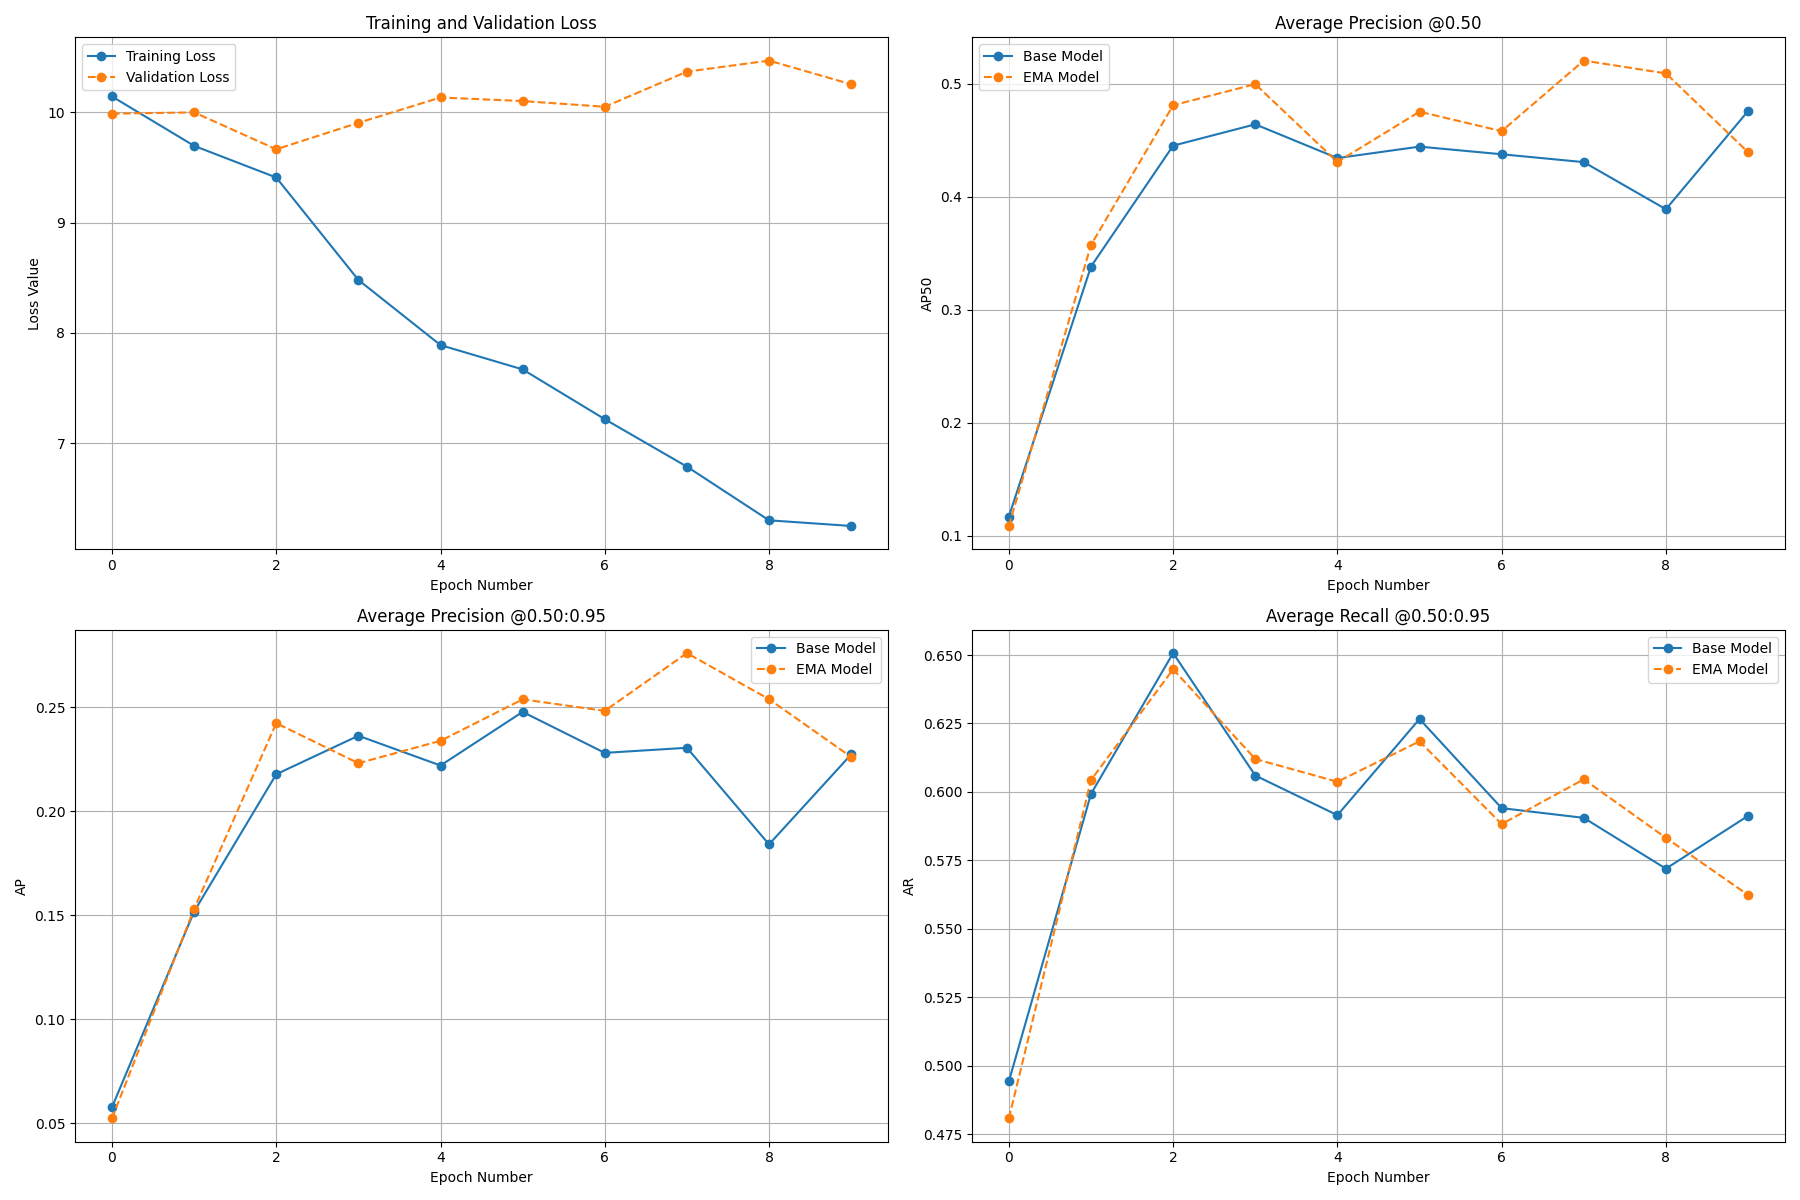

In [10]:
from PIL import Image
Image.open("/content/output/metrics_plot.png")

<br><br><br>

#**Model Inference**

In [13]:
import supervision as sv

# load test set from the roboflow dataset
ds = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/test",
    annotations_path=f"{dataset.location}/test/_annotations.coco.json",
)

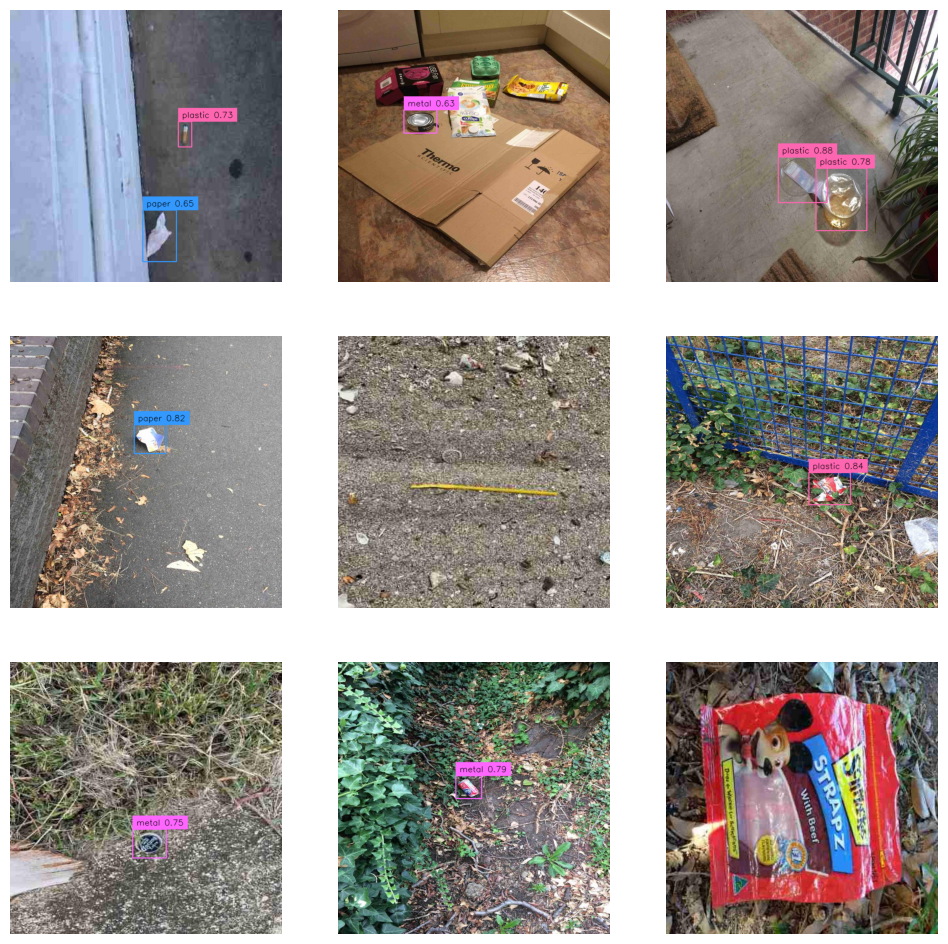

In [26]:
from PIL import Image

detections_images = []  # for storing annotated images

# run inference on 9 images
for i in range(9):
    path, image, annotations = ds[i]
    image = Image.open(path)

    # perform predictions
    detections = model.predict(image, threshold=0.5)

    text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
    thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)
    color = sv.ColorPalette.from_hex([
        "#ffff00", "#ff9b00", "#ff66ff", "#3399ff", "#ff66b2", "#ff8080",
        "#b266ff", "#9999ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
    ])

    # custom palette for boxes
    bbox_annotator = sv.BoxAnnotator(color=color, thickness=thickness)
    label_annotator = sv.LabelAnnotator(
        color=color,
        text_color=sv.Color.BLACK,
        text_scale=text_scale)

    # generate labels
    detections_labels = [
        f"{ds.classes[class_id]} {confidence:.2f}"
        for class_id, confidence
        in zip(detections.class_id, detections.confidence)
    ]


    # annotate images
    detections_image = image.copy()
    detections_image = bbox_annotator.annotate(detections_image, detections)
    detections_image = label_annotator.annotate(detections_image, detections, detections_labels)


    detections_images.append(detections_image)

# generate plot
sv.plot_images_grid(images=detections_images, grid_size=(3, 3), size=(12, 12))

<br><br><br>

#**4. Model Evaluation**

In [16]:
import supervision as sv
from tqdm import tqdm
from supervision.metrics import MeanAveragePrecision

targets = []
predictions = []

for path, image, annotations in tqdm(ds):
    image = Image.open(path)
    detections = model.predict(image, threshold=0.5)

    targets.append(annotations)
    predictions.append(detections)

100%|██████████| 55/55 [00:03<00:00, 16.82it/s]


In [17]:
map_metric = MeanAveragePrecision()
map_result = map_metric.update(predictions, targets).compute()
print(map_result)

Average Precision (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.165
Average Precision (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.335
Average Precision (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.123
Average Precision (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
Average Precision (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ]                 = 0.145
Average Precision (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ]                 = 0.204
